In [1]:
import sys
import numpy as np
import h5py
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
import IPython

%load_ext autoreload
%autoreload 2

In [12]:
# Open the HDF5 file
DATA_FOLDER = Path("/home/rai/Documents/MSCE/Sem2/ami/project_datashare")
filepath = DATA_FOLDER / "prediction.seg"
file = h5py.File(filepath, 'r')

# Access the dataset
# List dataset in the file
amplitude = file['amplitude/images']
phase = file['phase/images']
label = file['label/ground_truth']
mask = file['mask/images']

nimgs = np.shape(amplitude)[0]

mask_array = []
for img_idx in range(nimgs):
    mask_array.append([mask[img_idx]])

In [54]:
for key in file.keys():
    print(key)

amplitude
feature
label
mask
metadata
origin
phase


In [65]:
index = 15
mask_idx = mask[index]

In [122]:
num_pixels = cv2.countNonZero(mask_idx)
pixel_to_area_conv = 40 / 500 # 500 pixels are 40 micro m^2
pixel_to_length_conv = np.sqrt(pixel_to_area_conv)
area = pixel_to_area_conv * num_pixels

In [123]:
print(num_pixels)
print(area)

533
42.64


In [124]:
# Find the indices of non-zero pixels
indices = np.where(mask_idx != 0)

# Get the minimum and maximum coordinates
min_x, max_x = np.min(indices[1]), np.max(indices[1])
min_y, max_y = np.min(indices[0]), np.max(indices[0])

# Calculate the width and height of the mask
width = (max_x - min_x + 1) * pixel_to_length_conv
height = (max_y - min_y + 1) * pixel_to_length_conv

In [125]:
print(width)
print(height)

6.788225099390856
7.353910524340094


In [126]:
volume = width ** 2 * height * np.pi / 6
print(volume)

177.43097301829252


In [128]:
# Find contours in the image
contours, _ = cv2.findContours(mask_idx, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the perimeter
perimeter = cv2.arcLength(contours[0], True) * pixel_to_length_conv
print(perimeter)

23.507820830639645


In [129]:
roundness = 4 * np.pi * area / perimeter
print(roundness)

22.79369265473916


In [130]:
normalized_amplitude = amplitude[index] / 255

In [131]:
binary_mask = np.where(mask_idx != 0, True, False)
masked_normalized_amplitude = normalized_amplitude[binary_mask]

In [138]:
opacity = np.sum(1-masked_normalized_amplitude) / area
print(opacity)

12.171669793621012


In [136]:
mean_normalized_amplitude = np.sum(masked_normalized_amplitude) / num_pixels
print(mean_normalized_amplitude)

0.026017237335834897


In [96]:
amplitude_variance = np.sum((masked_normalized_amplitude - mean_normalized_amplitude) ** 2) / (num_pixels - 1)
print(amplitude_variance)

0.001434555627349624


In [99]:
amplitude_skewness = (np.sum((masked_normalized_amplitude - mean_normalized_amplitude) ** 3) / num_pixels ) / (np.sum((masked_normalized_amplitude - mean_normalized_amplitude) ** 2) / num_pixels)** 1.5
print(amplitude_skewness)

0.5019537933357487


In [100]:
masked_phase = phase[index][binary_mask]

In [102]:
max_phase = np.max(np.abs(masked_phase))
print(max_phase)

2.97


In [103]:
mean_phase = np.sum(masked_phase) / num_pixels
print(mean_phase)

1.25140712945591


In [104]:
phase_variance = np.sum((masked_phase- mean_phase) ** 2) / (num_pixels-1)
print(phase_variance)

0.6701127819548872


In [105]:
phase_skewness = (np.sum((masked_phase - mean_phase) ** 3) / num_pixels ) / (np.sum((masked_phase - mean_phase) ** 2) / num_pixels)** 1.5
print(phase_skewness)

-0.05259986544393922


In [107]:
wavelength = 530
refractive_increment = 0.2

In [140]:
dry_mass = pixel_to_area_conv * wavelength  / (1e3 * 2*np.pi*refractive_increment) * np.sum(masked_phase) # in picograms
print(dry_mass)

22.505145572966367


In [143]:
dry_mass_density = dry_mass / volume
print(dry_mass_density)

0.1268388781852995


In [147]:
def apply_kernel(image, kernel_size):
    image = image.astype(np.float32)
    # Define the kernel as a rectangular window of size r x r
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)

    # Pad the input image to handle border pixels
    image_padded = cv2.copyMakeBorder(image, kernel_size//2, kernel_size//2, kernel_size//2, kernel_size//2, cv2.BORDER_REFLECT)

    # Apply the kernel to the padded image using filter2D
    result_padded = cv2.filter2D(image_padded, -1, kernel)

    # Crop the output image to remove the padding
    result = result_padded[kernel_size//2:-kernel_size//2, kernel_size//2:-kernel_size//2]

    return result

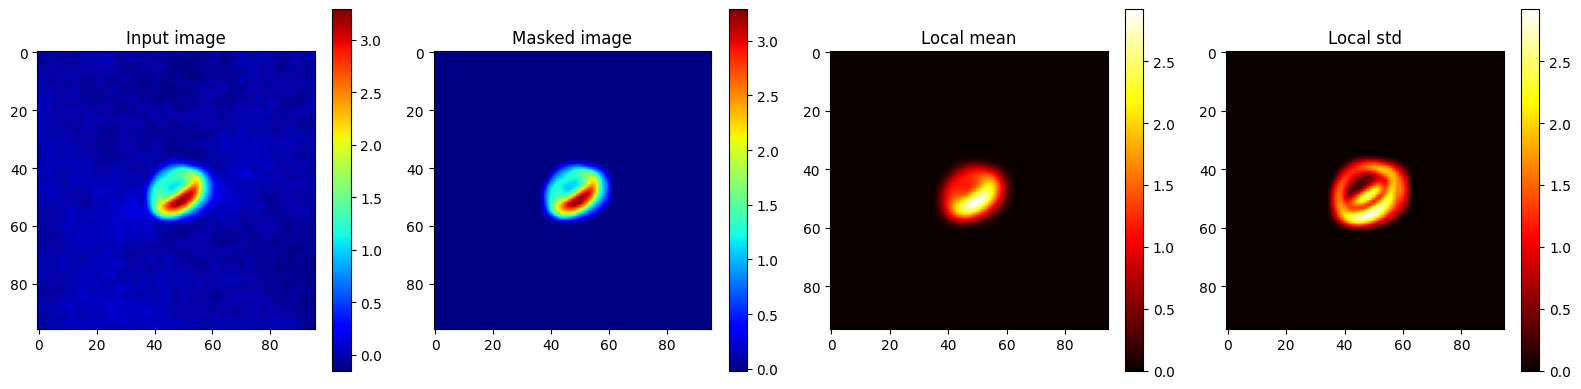

In [224]:
# Generate output image
test_index = 13

# Convert image and mask to appropriate data types
image = phase[test_index]  # Keep the phase image as a floating-point array
binary_mask = np.where(mask[test_index] != 0, 1, 0).astype(np.uint8)  # Convert mask to 0-1 binary mask

# Apply the mask to the image
masked_image = image * binary_mask
kernel_size = 5
phase_kernel = apply_kernel(masked_image, kernel_size=kernel_size)

image_squared_kernel = apply_kernel(masked_image ** 2, kernel_size=kernel_size)
phase_kernel_squared = phase_kernel ** 2

local_phase_std =  np.sqrt((kernel_size/(kernel_size - 1)) * (image_squared_kernel - phase_kernel_squared))
    
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

im1 = axs[0].imshow(image, cmap='jet')  # Use 'jet' colormap for input image
axs[0].set_title('Input image')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(masked_image, cmap='jet')  # Use 'jet' colormap for masked image
axs[1].set_title('Masked image')
fig.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(phase_kernel, cmap='hot')  # Use 'hot' colormap for result image
axs[2].set_title('Local mean')
fig.colorbar(im3, ax=axs[2])

im4 = axs[3].imshow(local_phase_std, cmap='hot')  # Use 'hot' colormap for result image
axs[3].set_title('Local std')
fig.colorbar(im3, ax=axs[3])

plt.tight_layout()
plt.show()

In [219]:
dc1 = np.sum(masked_phase) / num_pixels
print(mean_phase)

0.012805362579746496


In [220]:
dc2 = np.sqrt(np.sum((local_phase_std- dc1) ** 2) / (num_pixels-1))
print(dc2)

0.05101615887298114


In [221]:
dc3 = (np.sum((local_phase_std - dc1) ** 3) / num_pixels ) / (np.sum((local_phase_std - dc1) ** 2) / num_pixels)** 1.5
print(dc3)

-0.24800077965357817


In [227]:
np.shape(mask)

(111, 96, 96)

In [4]:
from feature_extractor import FeatureExtractor

In [13]:
fe = FeatureExtractor(phase, amplitude, mask_array)
fe.extract_features()

/home/rai/Documents/MSCE/Sem2/ami/Group06/notebooks/feature_extraction.py:133: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((kernel_pixels / (kernel_pixels - 1)) * (phase_squared_kernel - phase_kernel_squared))


,Volume,Roundness,Opacity,Amplitude Variance,Amplitude Skewness,Dry Mass Density,Max Phase,Phase Variance,Phase Skewness,DC1,DC2,DC3
0,192.216887,0.961294,12.440019,0.000404,0.222737,0.148152,3.511719,1.347115,0.151507,0.537326,4.729431,-0.244939
1,17.202843,1.043580,12.334858,0.000249,-0.321839,0.177625,1.396484,0.134606,0.224105,0.474834,16.368894,-0.117564
2,39.985946,0.987901,12.009360,0.000641,-0.167076,0.156106,1.624023,0.165807,0.210170,0.457755,8.904149,-0.153278
3,1027.158992,0.721094,12.389170,0.000297,-0.096284,0.087903,3.472656,0.955006,-0.100018,0.385540,0.701504,-0.444832
4,170.606705,0.983194,12.231250,0.000968,0.930308,0.123606,2.980469,0.761022,0.251738,0.452567,3.488324,-0.240690
...,...,...,...,...,...,...,...,...,...,...,...,...
106,150.418245,0.986904,12.466542,0.000206,0.403621,0.114736,2.093750,0.384657,-0.152236,0.359641,2.367460,-0.232401
107,17.202843,1.018127,11.425781,0.001215,-0.024194,0.165244,1.778320,0.227547,0.576090,0.511003,19.456771,-0.116086
108,48.528129,0.738422,12.455611,0.000122,0.748587,0.084173,1.414062,0.107143,0.211272,NaN,NaN,NaN
109,297.234792,0.933343,12.360747,0.000706,1.020639,0.174928,5.105469,2.511811,0.259282,0.617667,4.139719,-0.299315


In [14]:
df = fe.features

In [26]:
phase_mean_kernel = fe.phase_mean_kernel_array
phase_std_kernel = fe.phase_std_kernel_array

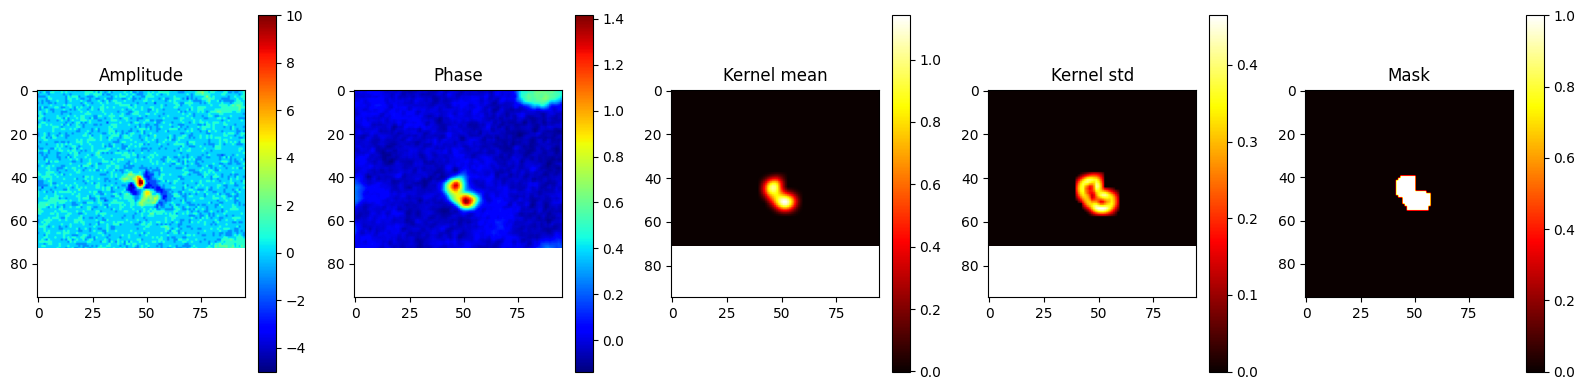

In [31]:
index = 108
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

im1 = axs[0].imshow(amplitude[index], cmap='jet')  # Use 'jet' colormap for input image
axs[0].set_title('Amplitude')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(phase[index], cmap='jet')  # Use 'jet' colormap for masked image
axs[1].set_title('Phase')
fig.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(phase_mean_kernel[index], cmap='hot')  # Use 'hot' colormap for result image
axs[2].set_title('Kernel mean')
fig.colorbar(im3, ax=axs[2])

im4 = axs[3].imshow(phase_std_kernel[index], cmap='hot')  # Use 'hot' colormap for result image
axs[3].set_title('Kernel std')
fig.colorbar(im4, ax=axs[3])

im5 = axs[4].imshow(mask[index], cmap='hot')  # Use 'hot' colormap for result image
axs[4].set_title('Mask')
fig.colorbar(im5, ax=axs[4])

plt.tight_layout()
plt.show()

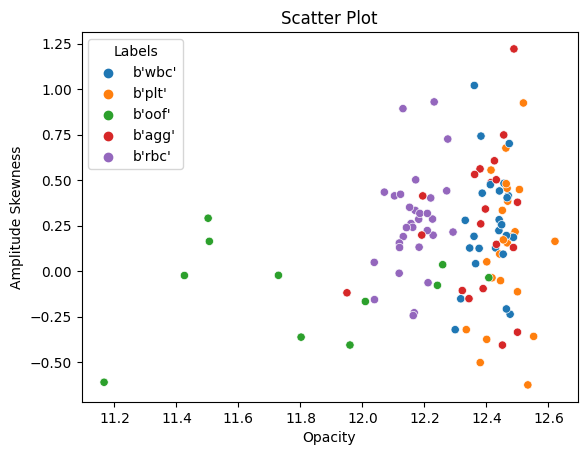

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df['Labels'] = label

sns.scatterplot(data=df, x='Opacity', y='Amplitude Skewness', hue='Labels')
plt.title('Scatter Plot')
plt.show()

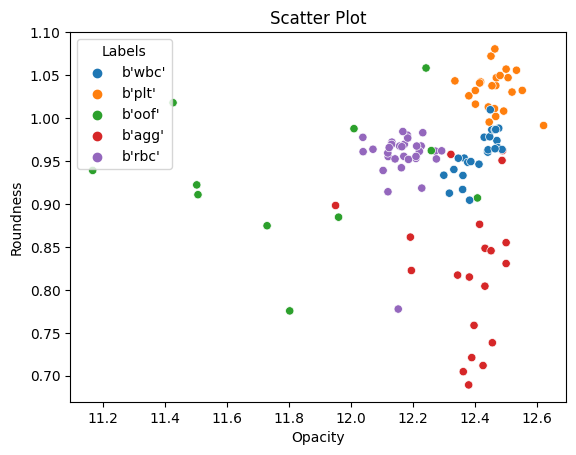

In [16]:
sns.scatterplot(data=df, x='Opacity', y='Roundness', hue='Labels')
plt.title('Scatter Plot')
plt.show()

In [61]:
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X = df.copy()
data=X.dropna()
del X['Labels']
tsne_results = tsne.fit_transform(data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 48.762755
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.945148
[t-SNE] KL divergence after 300 iterations: 0.066267
t-SNE done! Time elapsed: 0.3288919925689697 seconds


/tmp/ipykernel_147013/785612779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tsne-2d-one'] = tsne_results[:,0]
/tmp/ipykernel_147013/785612779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tsne-2d-two'] = tsne_results[:,1]
/tmp/ipykernel_147013/785612779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

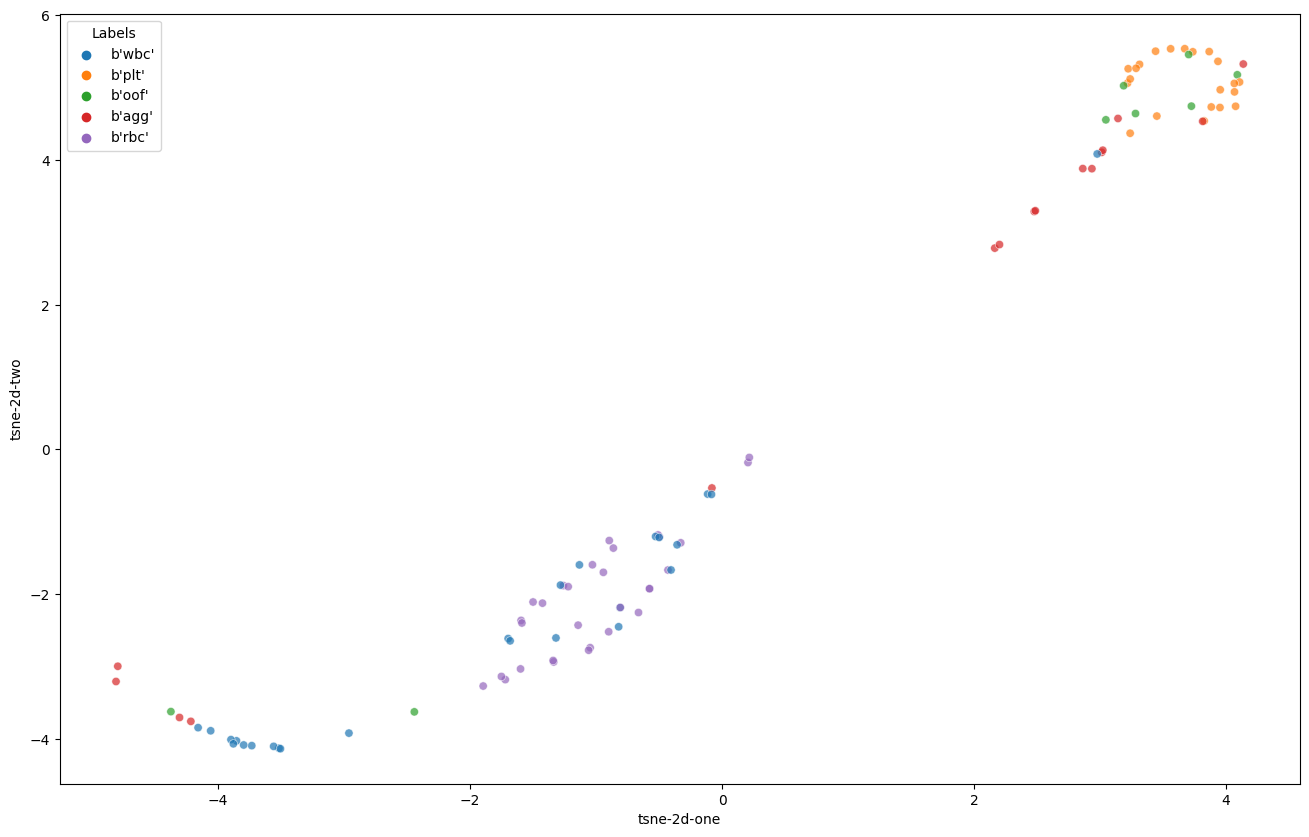

In [72]:
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
data['Labels'] = df['Labels']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Labels",
    #palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.7
)

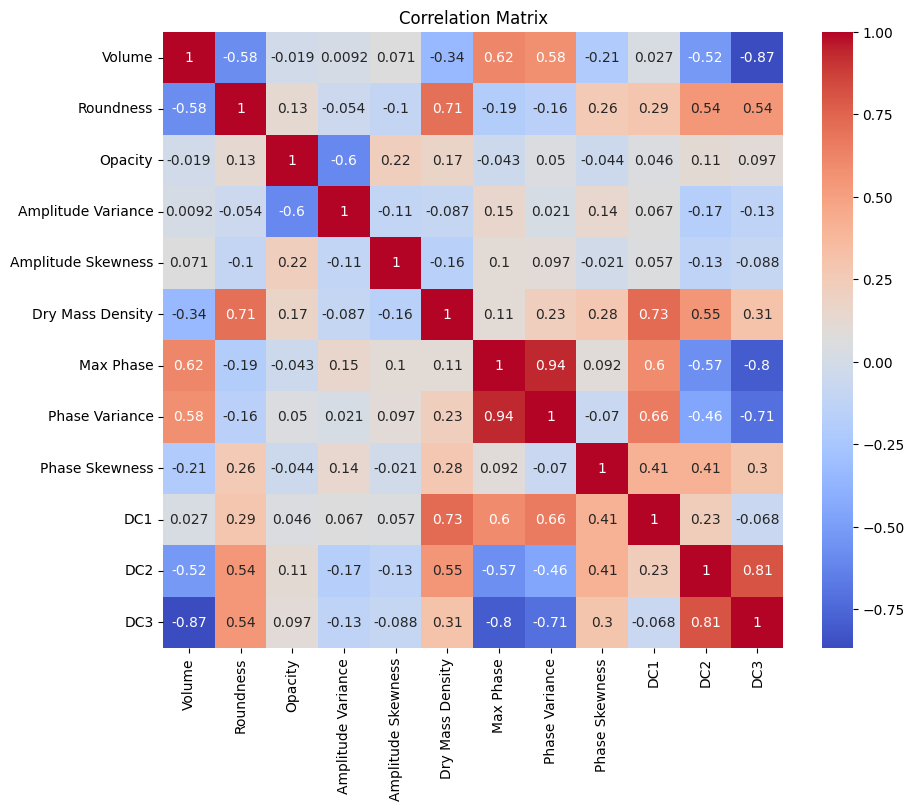

In [81]:
# Assuming you have a DataFrame called df with your features
correlation_matrix = X.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [87]:
# Assuming you have a DataFrame called df
corr_mat_abs = np.abs(correlation_matrix)
min_value = corr_mat_abs.min().min()  # Find the minimum value in the DataFrame
min_index = corr_mat_abs.stack().idxmin()  # Find the index label of the minimum value
min_column = corr_mat_abs[min_index[0]].idxmin()  # Find the column label of the minimum value

# Print the minimum value, index, and column
print("Minimum value:", min_value)
print("Minimum index:", min_index[0])
print("Minimum column:", min_column)

Minimum value: 0.009207013967979545
Minimum index: Volume
Minimum column: Amplitude Variance


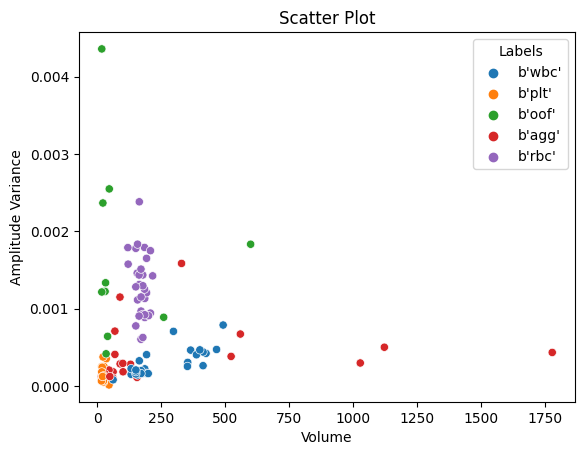

In [88]:
sns.scatterplot(data=df, x='Volume', y='Amplitude Variance', hue='Labels')
plt.title('Scatter Plot')
plt.show()

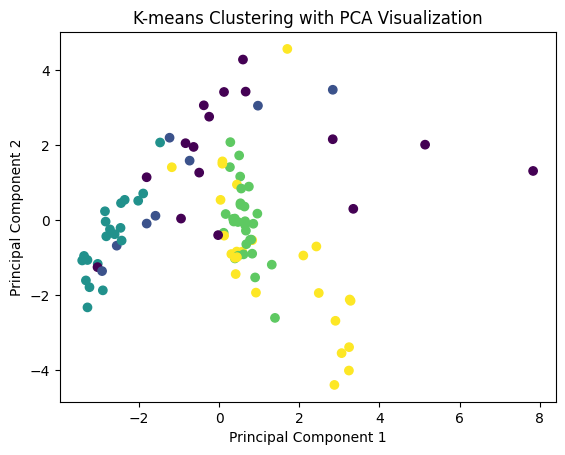

In [25]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is named 'df' and contains the features

# Step 1: Drop rows with NaN values
df.dropna(axis=0, inplace=True)

# Step 2: Prepare the data
df_copy = df.copy()
del df_copy['Labels']  # Remove the column with string labels if needed
X = df_copy

# Step 3: Encode string labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Labels'])

# Step 4: Apply PCA for dimensionality reduction
# Step 1: Preprocess the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Step 2: Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Step 3: Choose the number of components
explained_variance_ratio = pca.explained_variance_ratio_
variance_threshold = 0.95
total_variance = 0
n_components = 0

for explained_variance in explained_variance_ratio:
    total_variance += explained_variance
    n_components += 1
    if total_variance >= variance_threshold:
        break
n_components=2
# Step 4: Perform PCA with the chosen number of components
pca = PCA(n_components=n_components)
pca.fit(scaled_data)
transformed_data = pca.transform(scaled_data)

# Step 5: Visualize the clusters using PCA
if n_components == 2:
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=y)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('K-means Clustering with PCA Visualization')
    plt.show()
elif n_components == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=y)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('K-means Clustering with PCA Visualization')
    plt.show()

In [23]:
print(n_components)

7


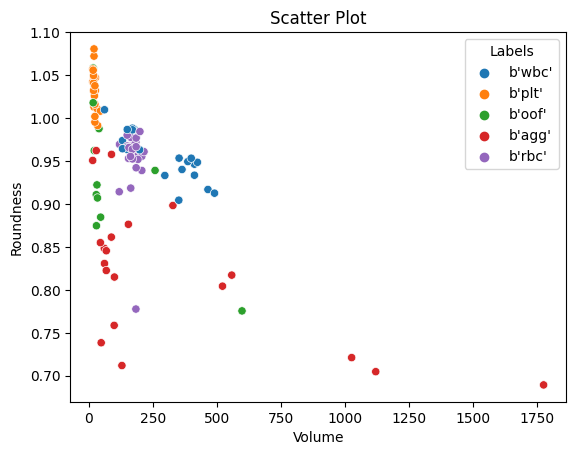

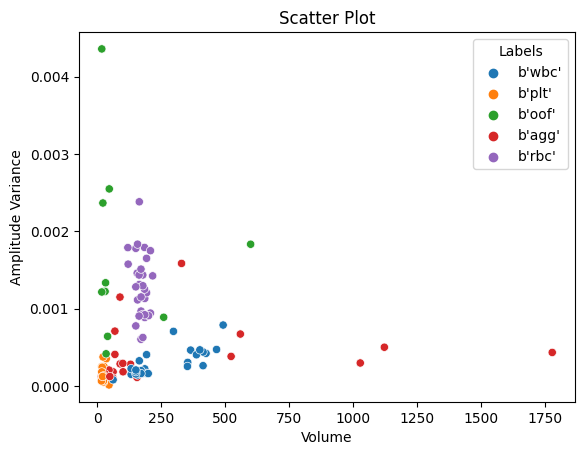

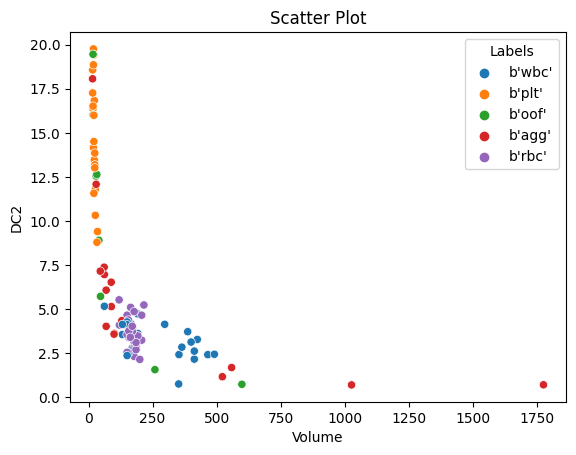

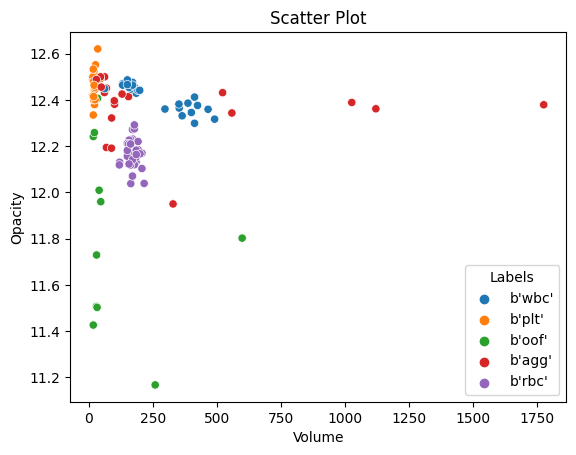

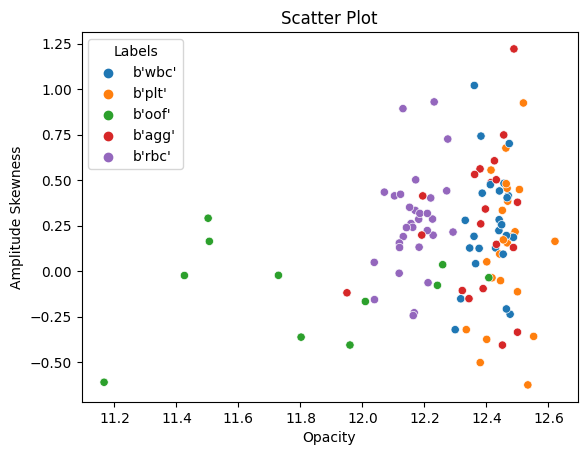

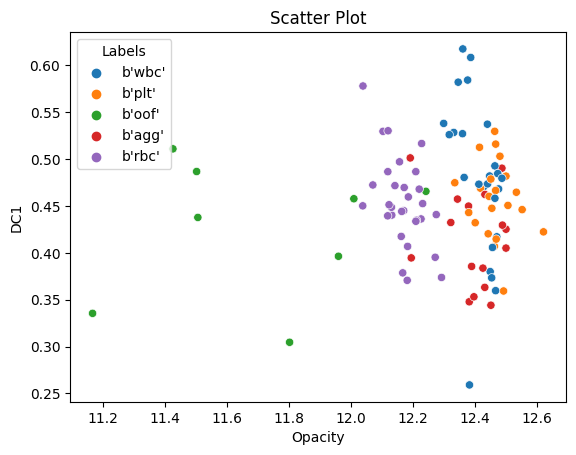

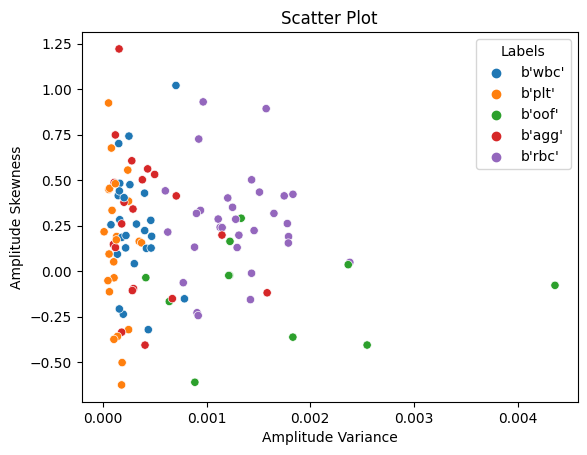

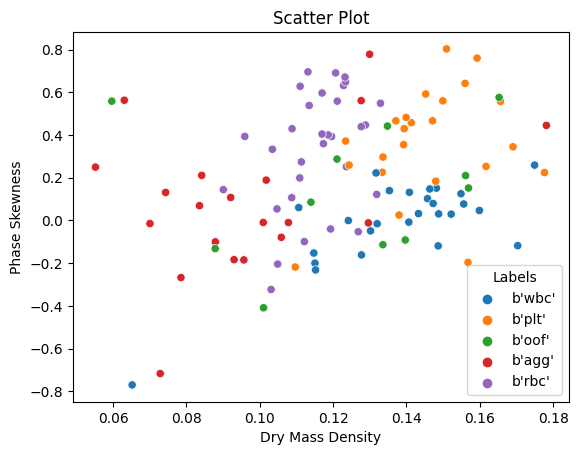

In [17]:
sns.scatterplot(data=df, x='Volume', y='Roundness', hue='Labels')
plt.title('Scatter Plot')
plt.show()

sns.scatterplot(data=df, x='Volume', y='Amplitude Variance', hue='Labels')
plt.title('Scatter Plot')
plt.show()
sns.scatterplot(data=df, x='Volume', y='DC2', hue='Labels')
plt.title('Scatter Plot')
plt.show()
sns.scatterplot(data=df, x='Volume', y='Opacity', hue='Labels')
plt.title('Scatter Plot')
plt.show()
sns.scatterplot(data=df, x='Opacity', y='Amplitude Skewness', hue='Labels')
plt.title('Scatter Plot')
plt.show()
sns.scatterplot(data=df, x='Opacity', y='DC1', hue='Labels')
plt.title('Scatter Plot')
plt.show()
sns.scatterplot(data=df, x='Amplitude Variance', y='Amplitude Skewness', hue='Labels')
plt.title('Scatter Plot')
plt.show()
sns.scatterplot(data=df, x='Dry Mass Density', y='Phase Skewness', hue='Labels')
plt.title('Scatter Plot')
plt.show()